# IMPORTACION DE LIBRERIAS Y LECTURA DEL DATASET

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
from tabulate import tabulate
import math

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid",font_scale=1, palette="pastel")

#Libreria para separacion de datos train y test
import pickle
from pprint import pprint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer


# Librerias a usar para el modelo de machine learning
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting

In [2]:
# Flag que indica, cuando es True, que es la última vez que se entrena al modelo definitivo y se puede guardar
save_pickle = False

In [25]:
# transformador personalizado que realiza la corrección de Camel Case
class CamelCaseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column_name] = X_copy[self.column_name].apply(lambda x: 'Disloyal Customer' if x == 'disloyal Customer' else x)
        return X_copy

In [3]:
# Function que facilita la exploración básica del dataset
def summary(df):
    total_values = df.shape[0]
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / total_values) * 100
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} rows.")    
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary['Missing %'] = ((missing_data / total_values) * 100).round(2)
    summary["Duplicated"] = df.duplicated().sum()
    summary["Types"] = df.dtypes
    return summary

In [4]:
#Lectura del dataset
df = pd.read_csv("airline_passenger_satisfaction.csv")

In [5]:
# Configura Pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

df.head(10)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
5,5,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,1,1,2,1,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,6,82113,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,3,2,2,2,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,7,96462,Female,Loyal Customer,52,Business travel,Business,2035,4,3,4,4,5,5,5,5,5,5,5,4,5,4,4,0.0,satisfied
8,8,79485,Female,Loyal Customer,41,Business travel,Business,853,1,2,2,2,4,3,3,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
9,9,65725,Male,disloyal Customer,20,Business travel,Eco,1061,3,3,3,4,2,3,3,2,2,3,4,4,3,2,0,0.0,neutral or dissatisfied


# NULOS E IMPUTACION DE NULOS

- Se mira información del dataset: columnas 25, filas 103903, y solo la columna Arrival Delay in Minutes tiene nulos.

In [ ]:
df.info()

- Se rectifica que solo haya una columna con datos nulos efectivamente solo hay en la columna Arrival Delay in Minutes **310 datos nulos**, posteriormente se decidirá que hacer con estos nulos.

In [ ]:
summary(df)

**Observaciones**

- Columnas Unnamed, id no creo que sean importantes y se podrían eliminar. Además tienen una cardinalidad muy alta
- La columna Baggage handlingtiene 5 valores en vez de 6 como todas las demás. Empieza en 1 en vez de 0
- Arrival Delay in Minutes es la única que es flotante pasarla a int.
- Arrival Delay in Minutes es la única que tiene missign values = 310, un 0.3% Muy poquito.Imputamos

- Revisamos los valores unicos de la columna "Arrival Delay in Minutes" para ver si se podia pasar de float a int.

In [ ]:
# Utiliza el método unique() para obtener todos los valores únicos
unique_values = df['Arrival Delay in Minutes'].unique()

# Muestra todos los valores únicos en la columna 'Arrival Delay in Minutes'
#for value in unique_values:
    #print(value)

In [6]:
# Para llenar los valores nulos con la media: (MIRAR SI SE IMPUTAN CON MEDIA O MEDIANA)
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mean())

# Para eliminar las filas con valores nulos
#df.dropna(subset=['Arrival Delay in Minutes'], inplace=True)

In [7]:
df['Arrival Delay in Minutes'].head()

0    18.0
1     6.0
2     0.0
3     9.0
4     0.0
Name: Arrival Delay in Minutes, dtype: float64

- La columna 'Arrival Delay in Minutes' se puede pasar a int ya que no tiene valores que se consideren decimales.

In [8]:
# Para convertir una columna de tipo float a int 
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype(int)

In [9]:
df['Arrival Delay in Minutes'].head()

0    18
1     6
2     0
3     9
4     0
Name: Arrival Delay in Minutes, dtype: int32

### SE BORRAN COLUMNAS QUE NO SIRVEN 

In [10]:
columna_a_borrar = ['Unnamed: 0', "id"]
df = df.drop(columna_a_borrar, axis=1)

# Exploratory Data Analysis (EDA)
## Target Variable

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='satisfaction')

In [ ]:
opiniones_neutral_or_dissatisfied =(df['satisfaction'] == 'neutral or dissatisfied').sum()
# Imprimir la suma de opiniones "neutral or dissatisfied"
print("Suma de opiniones 'neutral or dissatisfied':", opiniones_neutral_or_dissatisfied)

In [ ]:
opiniones_satisfied=(df['satisfaction'] == 'satisfied').sum()
# Imprimir la suma de opiniones "satisfied"
print("Suma de opiniones 'satisfied':",opiniones_satisfied)

- La variable esta balanceada, de momento se puede dejar asi, en caso de que estuviese desbalanceada se aplicarian tecnicas para balancear los datos y que el modelo funcionara mucho mejor.

### GRAFICA DE SERVICIOS DE LA AEROLINEA

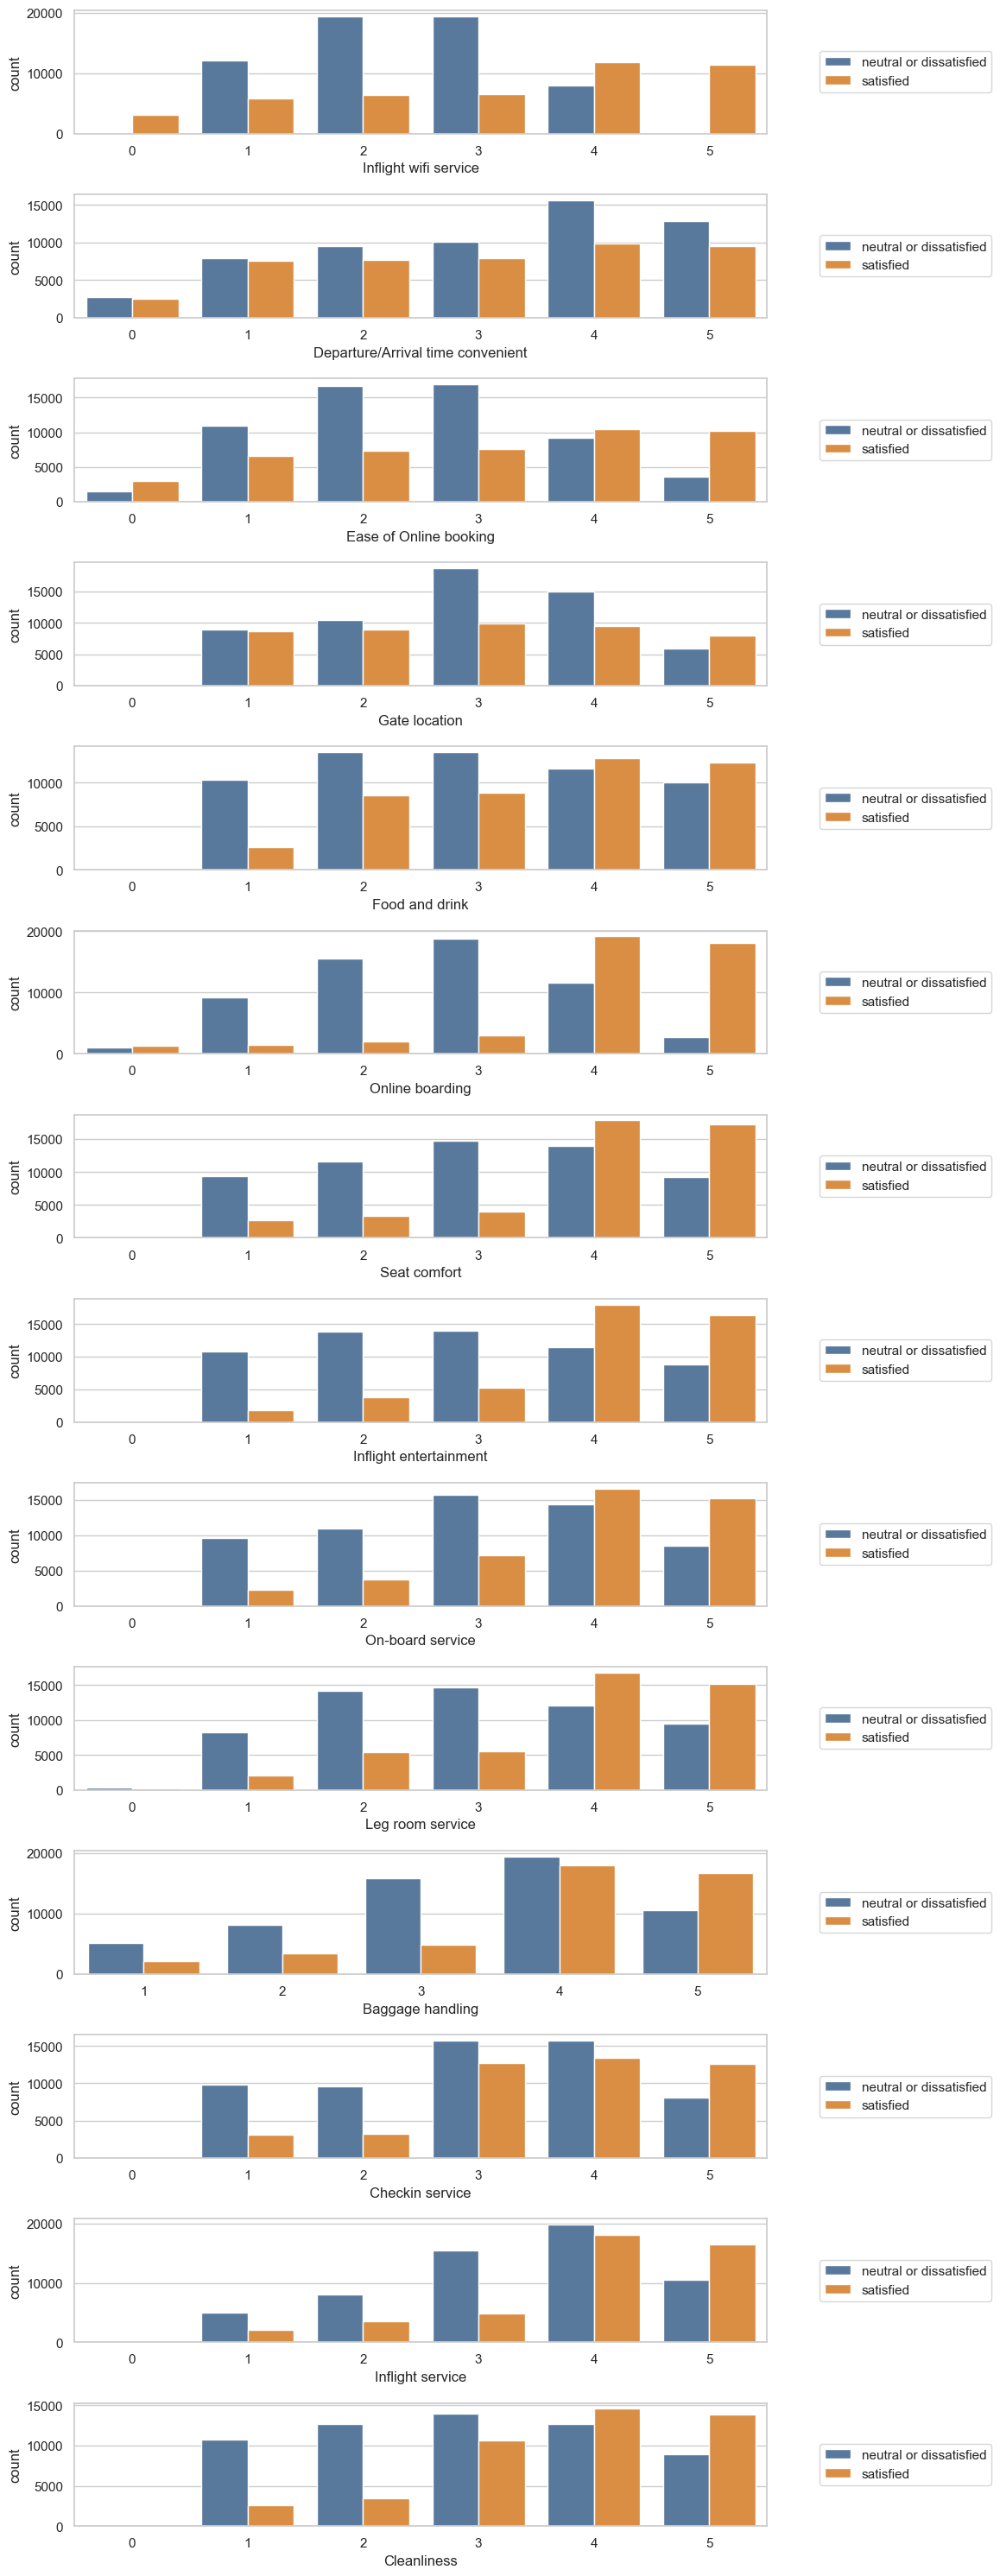

In [11]:
services = ["Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking", 'Gate location', 'Food and drink', 
            'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling',
            'Checkin service', 'Inflight service', 'Cleanliness']

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 30))  # Aumenta el valor 30 para adaptarlo a la cantidad de subplots que tengas

for idx, column in enumerate(services):
    plt.subplot(len(services), 1, idx+1)
    sns.countplot(x=column, hue="satisfaction", data=df, palette=["#4e79a7", "#f28e2b"])
    plt.legend(loc='center', bbox_to_anchor=(1.2, 0.5))

# Ajustar la disposición de las subtramas
plt.tight_layout()

# Mostrar la figura
plt.show()

# ANALISIS DE VARIABLES NUMERICAS

In [ ]:
df.describe()

In [12]:
num_cols = ["Age","Flight Distance","Inflight wifi service","Departure/Arrival time convenient","Ease of Online booking",
                 "Gate location","Food and drink","Online boarding","Seat comfort","Inflight entertainment","On-board service",
                 "Leg room service","Baggage handling","Checkin service","Inflight service","Cleanliness","Departure Delay in Minutes",
                 "Arrival Delay in Minutes"]

### SE GRAFICAN OUTLIERS DE TODAS LAS COLUMNAS

In [ ]:
n_rows, n_cols = math.ceil(len(num_cols) / 2), 2
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
i = 0

for num_col in num_cols:
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(data=df, x=num_col, y="satisfaction", ax=ax[row, col])
    ax[row, col].set_xlabel(num_col, fontsize=12)
    ax[row, col].set_ylabel('Satisfaction', fontsize=12)
    i += 1

# Ajusta la disposición de los subplots
plt.tight_layout()

# Muestra los gráficos
plt.show()

### ANALISIS DE COLUMNA "AGE"

In [ ]:
df['Age'].describe()

In [ ]:
plt.figure(figsize=(16,6))
sns.histplot(data=df, x="Age",  hue='satisfaction')
plt.title('Age Feature Distribution')

### - Intentamos hacer graficos de barras para visualizar si las respuestas estan en una desigualdad alta

In [ ]:
# Calcula el número de filas y columnas para organizar los subplots
n_rows, n_cols = math.ceil(len(num_cols) / 2), 2

# Crea la figura y los ejes de los subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
i = 0

for num_col in num_cols:
    row = i // n_cols
    col = i % n_cols
    sns.barplot(data=df, x="satisfaction", y=num_col, ax=ax[row, col])
    ax[row, col].set_xlabel("Satisfaction", fontsize=12)
    ax[row, col].set_ylabel(num_col, fontsize=12)
    i += 1

# Ajusta la disposición de los subplots
plt.tight_layout()

# Muestra los gráficos
plt.show()

# CamelCase para `Customer Type`

In [26]:
df['Customer Type'].head()

0       Loyal Customer
1    disloyal Customer
2       Loyal Customer
3       Loyal Customer
4       Loyal Customer
Name: Customer Type, dtype: object

In [27]:
# Cambiar solo 'disloyal Customer' a 'Disloyal Customer'. Acordarme de ponerlo en el pipeline
df.loc[df['Customer Type'] == 'disloyal Customer', 'Customer Type'] = 'Disloyal Customer'

In [28]:
df['Customer Type'].head()

0       Loyal Customer
1    Disloyal Customer
2       Loyal Customer
3       Loyal Customer
4       Loyal Customer
Name: Customer Type, dtype: object

In [ ]:
df[["Seat comfort"]].value_counts()

In [ ]:
df[["Inflight wifi service"]].value_counts()

### MAPA DE CORRELACION CON COLUMNAS NUMERICAS

In [ ]:
correlacion_numericas = df[num_cols].corr()

# Generamos una máscara para no duplicar los valores
mask = np.triu(np.ones_like(correlacion_numericas, dtype=bool))
#sns.heatmap(correlacion_numericas , mask = mask, annot =True , linewidth =0.2)

# Crear el heatmap
plt.figure(figsize=(15, 10))  # Ajusta el tamaño de la figura, puede ponerse o no.10,8
#sns.heatmap(correlacion_numericas , mask = mask, annot =True , linewidth =0.2)
sns.heatmap(correlacion_numericas,  mask = mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.2) # lw= 0.5
plt.title('Heatmap de Correlación entre Columnas')
plt.show()

# ANALISIS DE VARIABLES CATEGORICAS

### Revisamos cuantas y cuales columnas categoricas hay

In [13]:
cat_cols =[column for column, count in dict(df.nunique()).items()
             if (df[column].dtype=="O") & (count<10)]
cat_cols

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

### Obtenemos las columnas con sus datos categoricos

In [14]:
# Obtener categorías únicas (incluyendo valores nulos) de las columnas deseadas
categorias_por_columna = {}
for columna in cat_cols:
    categorias = df[columna].unique()
    categorias = [str(cat) if not pd.isnull(cat) else 'NaN' for cat in categorias]
    categorias_por_columna[columna] = categorias

# Mostrar las categorías en una tabla usando tabulate
tabla = []
for columna, categorias in categorias_por_columna.items():
    tabla.append([columna, ", ".join(categorias)])

tabla_formateada = tabulate(tabla, headers=["Columna", "Datos Categorícos (con Nulos)"], tablefmt="grid")
print(tabla_formateada)

+----------------+------------------------------------+
| Columna        | Datos Categorícos (con Nulos)      |
+================+====================================+
| Gender         | Male, Female                       |
+----------------+------------------------------------+
| Customer Type  | Loyal Customer, disloyal Customer  |
+----------------+------------------------------------+
| Type of Travel | Personal Travel, Business travel   |
+----------------+------------------------------------+
| Class          | Eco Plus, Business, Eco            |
+----------------+------------------------------------+
| satisfaction   | neutral or dissatisfied, satisfied |
+----------------+------------------------------------+


### VISUALIZAMOS CON GRAFICO DE BARRAS LAS VARIABLES CATEGORICAS

In [ ]:
# Calcula el número de filas y columnas para organizar los subplots
n_rows, n_cols = math.ceil(len(cat_cols) / 2), 2

# Crea la figura y los ejes de los subplots
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
i = 0

for var_cat in cat_cols:
    row = i // n_cols
    col = i % n_cols
    sns.countplot(data=df, x=var_cat, hue="satisfaction", ax=ax[row, col])
    ax[row, col].set_xlabel(var_cat, fontsize=12)
    ax[row, col].set_ylabel('Count', fontsize=12)
    i += 1

# Ajusta la disposición de los subplots
plt.tight_layout()

# Muestra los gráficos
plt.show()

# OUTLIERS

LAS SIGUIENTES LINEAS DE CODIGO SE USARÁN PARA BUSCAR OUTLIERS Y BORRARLOS

In [15]:
mean = df["Flight Distance"].mean()
std = df["Flight Distance"].std()

threshold = 3 * std

outliers = df[abs(df["Flight Distance"] - mean) > threshold]

In [16]:
df = df.drop(index=outliers.index)

# PRE PROCESAMIENTO: DIVISION DE DATOS

- La siguiente funcion se usará cuando el modelo ya esté entrenado y es para medir la capacidad del modelo

In [ ]:
df.head(15)


In [ ]:
columnas = df.columns.tolist()
columnas



In [ ]:
df.shape

## Definición de funciones

In [29]:
# Función para convertir a int
def to_int(series):
    return series.astype(int)

In [30]:
# Función para convertir a Camel Case
def camel_case(text):
    words = text.split()
    camel_case_text = ''.join([word.capitalize() for word in words])
    return camel_case_text

In [31]:
def model_pred(model, flag):
    
    # Definimos los pipeline aqui. 
    
    #pipe_steps(model, num_cols, cat_cols)
    

    # Transformador para la columna 'Arrival Delay in Minutes'
    #delay_transformer = FunctionTransformer(func=to_int)
    
    # Transformador para la columna 'Customer Type' para CamelCase
    #customer_transformer = FunctionTransformer(func=camel_case)
        
    
    
    num_transformer = Pipeline(steps=[
    #('delay_to_int', delay_transformer),      
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', MinMaxScaler())
    ])

    cat_transformer = Pipeline(steps=[
        #('correct_disloyal', CorrectDisloyalCustomer(column_name='Customer Type')),  # transformador personalizado
        ('imputerc', SimpleImputer(strategy="most_frequent")),    
        ('encoder', OneHotEncoder(sparse=False)), 
    ])

    #Aplicar los transformer a nuestras features usando ColumnTransformer, es nuestro pre-procesamiento.
    # Ojo se van a cambiar las letra inicial a capital de Disloyal?, se hace en un pipeline? Se deja arreglado
    # en la encuesta

    preprocessor = ColumnTransformer(
        transformers=[
           ('numeric', num_transformer, num_cols),
           ('categorical', cat_transformer, cat_cols)
        ])
    
    
    # Estimator o modelo a aplicar
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('modelo', model)
    ])
    
    
     
    # Aplicar el pipeline a los datos de entrenamiento
    pipeline.fit(X_train, y_train) # ESte está correcto.
    
    # Obtiene las predicciones del modelo en los datos de entrenamiento
    y_train_pred = pipeline.predict(X_train)
       
    # Preprocesa (transforma) los datos de prueba
    X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

    # Obtiene las predicciones del modelo en los datos de prueba transformados
    y_test_pred = pipeline.named_steps['modelo'].predict(X_test_transformed)
    
    
    if flag:
        # Guardar el pipeline usando Pickle. Por qué  lo estoy guardando aquí?
        with open('data_pipeline.pkl', 'wb') as file:
            pickle.dump(pipeline, file)
    
    # ********************** Calcula Métricas ********************************
        
    a = accuracy_score(y_train,y_train_pred)*100
    b = accuracy_score(y_test,y_test_pred)*100
    
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    
    print("\n------------------------------------------------------------------------")
    print(f"Precision Score of {model} model is:",precision_score(y_test,y_test_pred, pos_label='satisfied'))
    print(f"Recall Score of {model} model is:",recall_score(y_test,y_test_pred, pos_label='satisfied'))
    print(f"F1 Score of {model} model is:",f1_score(y_test,y_test_pred, pos_label='satisfied'))
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test,y_test_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt="g",cmap="summer")
    plt.show()
    
    #return pipeline


## SEPARACION DE CARACTERISTICAS Y VARIABLE OBJETIVO

In [32]:
num_cols = ["Age","Flight Distance","Inflight wifi service","Departure/Arrival time convenient", "Ease of Online booking",
                 "Gate location", "Food and drink", "Online boarding", "Seat comfort", "Inflight entertainment", "On-board service",
                 "Leg room service", "Baggage handling", "Checkin service", "Inflight service", "Cleanliness", "Departure Delay in Minutes",
                 "Arrival Delay in Minutes"]

cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

In [33]:
# Separar Variable Objetivo, target o variable dependiente de las variables independientes
df_f = pd.DataFrame(df)
y = df_f["satisfaction"]
X = df_f.drop(columns="satisfaction")

In [34]:
# Divido los dataset en training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Columnas categóricas y numéricas. 
#num_cols = ['Inflight wifi service', 'Food and drink']
#cat_cols = ['Customer Type', 'Gender'] 

In [ ]:
# Definir los mejores parámetros (estos parametros se definieron ya habiendo corrido
# la sigueinte linea de cosigo que buscaron los mejores parametros)
best_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}

# Crear un modelo de Gradient Boosting con los mejores parámetros
gb_model = GradientBoostingClassifier(**best_params)

# Crear el pipeline que combina el preprocesador y el modelo.
#pipeline = Pipeline(steps=[
#    ('preprocessor', preprocessor),
#    ('gradient_boosting', gb_model)
#])

## BUSQUEDA DE HIPERPARAMETROS

Con este codigo se buscaron los mejores hiperparametro los cuales se utilizan y ya se comenta para no tener que usar mas esta linea de codigo y poner mas lento el programa.

Best Gradient Boosting Model - Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}

In [ ]:
# Definir la cuadrícula de hiperparámetros a explorar
# param_grid = {
    #'n_estimators': [50, 100, 150],
    #'learning_rate': [0.01, 0.1, 0.2],
    #'max_depth': [3, 5, 7]

# Realizar Grid Search con validación cruzada
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
#grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el mejor modelo
# best_params = grid_search.best_params_
# best_gb_model = grid_search.best_estimator_

# print("Best Gradient Boosting Model - Best Params:", best_params)

- A continuación, podemos usar el pipeline para entrenar y evaluar tu modelo.
Por ejemplo, puedes ajustar el pipeline a tus datos de entrenamiento y realizar predicciones:


# PROBANDO MODELOS

In [21]:
# Definir listas para almacenar los puntajes de precisión
training_score = []  # Lista para puntajes de precisión en datos de entrenamiento
testing_score = []   # Lista para puntajes de precisión en datos de prueba



In [ ]:
save_pickle

# Probamos los modelos

Accuracy_Score of LogisticRegression(penalty='l1', solver='liblinear') model on Training Data is: 87.54032452212432
Accuracy_Score of LogisticRegression(penalty='l1', solver='liblinear') model on Testing Data is: 87.59749638902264

------------------------------------------------------------------------
Precision Score of LogisticRegression(penalty='l1', solver='liblinear') model is: 0.8795449214168426
Recall Score of LogisticRegression(penalty='l1', solver='liblinear') model is: 0.8288019451812555
F1 Score of LogisticRegression(penalty='l1', solver='liblinear') model is: 0.8534198247410947

------------------------------------------------------------------------
Confusion Matrix of LogisticRegression(penalty='l1', solver='liblinear') model is:


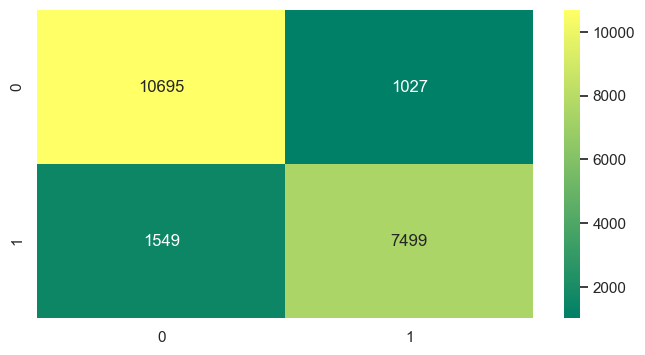

In [35]:
model_pred(LogisticRegression(solver= 'liblinear',penalty='l1'), save_pickle)
#model_prediction(LogisticRegression(solver= 'liblinear',penalty='l1'))

In [36]:
print(save_pickle)

False


In [ ]:
# KNeighborsClassifier
model_pred(KNeighborsClassifier(), save_pickle)

In [ ]:
model_pred(AdaBoostClassifier(n_estimators=200,  random_state=1), save_pickle)

# Comparación de los modelos


In [ ]:
print(training_score)
print(testing_score)

In [ ]:
models = ["Logistic Regression","KNN","Ada Boos Class"]

In [ ]:
df_comp = pd.DataFrame({"Algorithms":models,
                   "Training Score":training_score,
                   "Testing Score":testing_score})

In [ ]:
df_comp

# Entrenar con todos los datos al modelo escogido
#### Guardar el pickle ####

Accuracy_Score of AdaBoostClassifier(n_estimators=200, random_state=1) model on Training Data is: 92.96306996003659
Accuracy_Score of AdaBoostClassifier(n_estimators=200, random_state=1) model on Testing Data is: 93.22099181511796

------------------------------------------------------------------------
Precision Score of AdaBoostClassifier(n_estimators=200, random_state=1) model is: 0.9335981838819524
Recall Score of AdaBoostClassifier(n_estimators=200, random_state=1) model is: 0.9090406719717065
F1 Score of AdaBoostClassifier(n_estimators=200, random_state=1) model is: 0.9211557845223429

------------------------------------------------------------------------
Confusion Matrix of AdaBoostClassifier(n_estimators=200, random_state=1) model is:


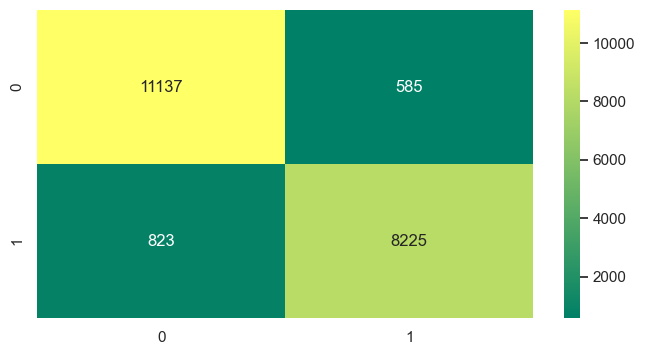

In [37]:
# Supongamos que escogemos AdaBoostClassifier. Volvemos a llamar a la función model_pred()

# Flag que indica, cuando es True, que es la última vez que se entrena al modelo definitivo y se puede guardar
save_pickle = True 
model_pred(AdaBoostClassifier(n_estimators=200,  random_state=1), save_pickle)
save_pickle = False


# ANALISIS DE CORRELACION

### CONCLUSION

- Edad: La edad tiene una correlación positiva débil (0.137) con la satisfacción. Esto sugiere que los pasajeros mayores tienden a estar ligeramente más satisfechos en comparación con los pasajeros más jóvenes.
- Distancia del Vuelo (Flight Distance): La distancia del vuelo tiene una correlación negativa moderada (-0.299) con la satisfacción. Esto indica que a medida que la distancia del vuelo aumenta, la satisfacción tiende a disminuir. Los vuelos más largos podrían estar asociados con niveles de satisfacción más bajos.
  
- Embarque en Línea (Online Boarding): La variable "Online Boarding" tiene una correlación negativa fuerte (-0.503) con la satisfacción. Esto significa que los pasajeros que tienen una experiencia de embarque en línea mejor tienden a estar más satisfechos con el servicio.
  
- Comodidad del Asiento (Seat Comfort): La comodidad del asiento tiene una correlación positiva fuerte (0.349) con la satisfacción. Los pasajeros que encuentran cómodos los asientos tienden a estar más satisfechos.

- Entretenimiento a Bordo (Inflight Entertainment): El entretenimiento a bordo tiene una correlación positiva fuerte (0.398) con la satisfacción. Los pasajeros que disfrutan del entretenimiento a bordo tienden a estar más satisfechos.

- Limpieza (Cleanliness): La limpieza tiene una correlación positiva moderada (0.305) con la satisfacción. Los pasajeros que perciben que la cabina está limpia tienden a estar más satisfechos.
  
- Clase (Class): La clase de vuelo también tiene una influencia en la satisfacción. La variable "Class_Eco" tiene una correlación negativa moderada con la satisfacción, mientras que "Class_Business" tiene una correlación positiva moderada. Esto sugiere que los pasajeros de clase económica pueden estar menos satisfechos en comparación con los pasajeros de clase business.
  
- Tipo de Viaje (Type of Travel): La variable "Type of Travel_Personal Travel" tiene una correlación negativa moderada con la satisfacción, lo que sugiere que los viajes de negocios podrían estar asociados con niveles de satisfacción más altos en comparación con los viajes personales.
  
- Tipo de Cliente (Customer Type): La variable "Customer Type_Loyal Customer" tiene una correlación positiva moderada con la satisfacción, lo que sugiere que los clientes leales tienden a estar más satisfechos.
  
- Tiempo de Llegada y Salida Conveniente (Departure/Arrival Time Convenient): Esta característica tiene una correlación positiva débil (0.052) con la satisfacción. Los pasajeros que consideran que el tiempo de llegada y salida es conveniente tienden a estar ligeramente más satisfechos.